In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
from torch.nn import Module
import torch
import torch.nn.functional as F

class FeedForward(Module):
    def __init__(self,
                 d_model: int,
                 d_hidden: int = 512):
        super(FeedForward, self).__init__()

        self.linear_1 = torch.nn.Linear(d_model, d_hidden)
        self.linear_2 = torch.nn.Linear(d_hidden, d_model)

    def forward(self, x):

        x = self.linear_1(x)
        x = F.relu(x)
        x = self.linear_2(x)

        return x

In [34]:
from torch.nn import Module
import torch
from torch.nn import CrossEntropyLoss

class Myloss(Module):
    def __init__(self):
        super(Myloss, self).__init__()
        self.loss_function = CrossEntropyLoss()

    def forward(self, y_pre, y_true):
        y_true = y_true.long()
        loss = self.loss_function(y_pre, y_true)

        return 

In [35]:
from torch.nn import Module
import torch
import math
import torch.nn.functional as F


class MultiHeadAttention(Module):
    def __init__(self,
                 d_model: int,
                 q: int,
                 v: int,
                 h: int,
                 device: str,
                 mask: bool=False,
                 dropout: float = 0.1):
        super(MultiHeadAttention, self).__init__()

        self.W_q = torch.nn.Linear(d_model, q * h)
        self.W_k = torch.nn.Linear(d_model, q * h)
        self.W_v = torch.nn.Linear(d_model, v * h)

        self.W_o = torch.nn.Linear(v * h, d_model)

        self.device = device
        self._h = h
        self._q = q

        self.mask = mask
        self.dropout = torch.nn.Dropout(p=dropout)
        self.score = None

    def forward(self, x, stage):
        Q = torch.cat(self.W_q(x).chunk(self._h, dim=-1), dim=0)
        K = torch.cat(self.W_k(x).chunk(self._h, dim=-1), dim=0)
        V = torch.cat(self.W_v(x).chunk(self._h, dim=-1), dim=0)

        score = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self._q)
        self.score = score

        if self.mask and stage == 'train':
            mask = torch.ones_like(score[0])
            mask = torch.tril(mask, diagonal=0)
            score = torch.where(mask > 0, score, torch.Tensor([-2**32+1]).expand_as(score[0]).to(self.device))

        score = F.softmax(score, dim=-1)

        attention = torch.matmul(score, V)

        attention_heads = torch.cat(attention.chunk(self._h, dim=0), dim=-1)

        self_attention = self.W_o(attention_heads)

        return self_attention, self.score

In [36]:
from torch.nn import Module
import torch

class Encoder(Module):
    def __init__(self,
                 d_model: int,
                 d_hidden: int,
                 q: int,
                 v: int,
                 h: int,
                 device: str,
                 mask: bool = False,
                 dropout: float = 0.1):
        super(Encoder, self).__init__()

        self.MHA = MultiHeadAttention(d_model=d_model, q=q, v=v, h=h, mask=mask, device=device, dropout=dropout)
        self.feedforward = FeedForward(d_model=d_model, d_hidden=d_hidden)
        self.dropout = torch.nn.Dropout(p=dropout)
        self.layerNormal_1 = torch.nn.LayerNorm(d_model)
        self.layerNormal_2 = torch.nn.LayerNorm(d_model)

    def forward(self, x, stage):

        residual = x
        x, score = self.MHA(x, stage)
        x = self.dropout(x)
        x = self.layerNormal_1(x + residual)

        residual = x
        x = self.feedforward(x)
        x = self.dropout(x)
        x = self.layerNormal_2(x + residual)

        return x, score

In [37]:
from torch.nn import Module
import torch
from torch.nn import ModuleList
import math
import torch.nn.functional as F


class Transformer(Module):
    def __init__(self,
                 d_model: int,
                 d_input: int,
                 d_channel: int,
                 d_output: int,
                 d_hidden: int,
                 q: int,
                 v: int,
                 h: int,
                 N: int,
                 device: str,
                 dropout: float = 0.1,
                 pe: bool = False,
                 mask: bool = False):
        super(Transformer, self).__init__()

        self.encoder_list_1 = ModuleList([Encoder(d_model=d_model,
                                                  d_hidden=d_hidden,
                                                  q=q,
                                                  v=v,
                                                  h=h,
                                                  mask=mask,
                                                  dropout=dropout,
                                                  device=device) for _ in range(N)])

        self.encoder_list_2 = ModuleList([Encoder(d_model=d_model,
                                                  d_hidden=d_hidden,
                                                  q=q,
                                                  v=v,
                                                  h=h,
                                                  dropout=dropout,
                                                  device=device) for _ in range(N)])

        self.embedding_channel = torch.nn.Linear(d_channel, d_model)
        self.embedding_input = torch.nn.Linear(d_input, d_model)

        self.gate = torch.nn.Linear(d_model * d_input + d_model * d_channel, 2)
        self.output_linear = torch.nn.Linear(d_model * d_input + d_model * d_channel, d_output)

        self.pe = pe
        self._d_input = d_input
        self._d_model = d_model

    def forward(self, x, stage):
        
        encoding_1 = self.embedding_channel(x)
        input_to_gather = encoding_1

        if self.pe:
            pe = torch.ones_like(encoding_1[0])
            position = torch.arange(0, self._d_input).unsqueeze(-1)
            temp = torch.Tensor(range(0, self._d_model, 2))
            temp = temp * -(math.log(10000) / self._d_model)
            temp = torch.exp(temp).unsqueeze(0)
            temp = torch.matmul(position.float(), temp)  # shape:[input, d_model/2]
            pe[:, 0::2] = torch.sin(temp)
            pe[:, 1::2] = torch.cos(temp)

            encoding_1 = encoding_1 + pe

        for encoder in self.encoder_list_1:
            encoding_1, score_input = encoder(encoding_1, stage)

        
        encoding_2 = self.embedding_input(x.transpose(-1, -2))
        channel_to_gather = encoding_2

        for encoder in self.encoder_list_2:
            encoding_2, score_channel = encoder(encoding_2, stage)


        encoding_1 = encoding_1.reshape(encoding_1.shape[0], -1)
        encoding_2 = encoding_2.reshape(encoding_2.shape[0], -1)

        # gate
        gate = F.softmax(self.gate(torch.cat([encoding_1, encoding_2], dim=-1)), dim=-1)
        encoding = torch.cat([encoding_1 * gate[:, 0:1], encoding_2 * gate[:, 1:2]], dim=-1)


        output = self.output_linear(encoding)

        return output, encoding, score_input, score_channel, input_to_gather, channel_to_gather, gate

In [38]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from time import time
from tqdm import tqdm
import os
import numpy as np
import tensorflow as tf
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split



#setup_seed(30) 


EPOCH = 150
BATCH_SIZE = 64
LR = 0.001
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  
print(f'use device: {DEVICE}')

d_model = 256
d_hidden = 256
q = 4
v = 4
h = 4
N = 5
dropout = 0.2

X = np.load('/content/(N_W)X_Data.npy',allow_pickle=True)
Y = np.load('/content/(N_W)Y_Data.npy',allow_pickle=True)


train_dataset, test_dataset, y_train , y_test  = train_test_split(X, Y, test_size = 0.30, random_state = 150, shuffle=True)

#train_dataset = np.load("/content/X_train_equal.npy", allow_pickle=True)
#test_dataset = np.load("/content/X_test_equal.npy",allow_pickle=True)

#y_train = np.load("/content/Y_train_equal.npy",allow_pickle=True)
#y_test = np.load("/content/Y_test_equal.npy",allow_pickle=True)

train_dataset = np.asarray(train_dataset).astype('float32')
test_dataset = np.asarray(test_dataset).astype('float32')

y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

y_test = np.array(y_test).flatten()
y_train = np.array(y_train).flatten()
#y_train = tf.keras.utils.to_categorical(y_train)
#y_test = tf.keras.utils.to_categorical(y_test)

train_dataset = train_dataset.reshape((train_dataset.shape[0], 98, 2))
test_dataset = test_dataset.reshape((test_dataset.shape[0], 98, 2))

tensor_x = torch.Tensor(train_dataset) # transform to torch tensor
tensor_y = torch.Tensor(y_train)
tensor_xx = torch.Tensor(test_dataset) # transform to torch tensor
tensor_yy = torch.Tensor(y_test)

my_dataset_train = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataset_test = TensorDataset(tensor_xx,tensor_yy)


train_dataloader = DataLoader(dataset=my_dataset_train, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(dataset=my_dataset_test, batch_size=BATCH_SIZE, shuffle=False)

DATA_LEN = train_dataset.shape[0]
Data_Len = test_dataset.shape[0] 
d_input = 98  
d_channel = 2 
d_output = 2


print('data structure: [lines, timesteps, features]')
print(f'train data size: [{DATA_LEN, d_input, d_channel}]')
print(f'test data size: [{Data_Len, d_input, d_channel}]')
print(f'Number of classes: {d_output}')


net = Transformer(d_model=d_model, d_input=d_input, d_channel=d_channel, d_output=d_output, d_hidden=d_hidden,
                  q=q, v=v, h=h, N=N, dropout=dropout, device=DEVICE).to(DEVICE)

loss_function = CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LR)





use device: cuda:0
data structure: [lines, timesteps, features]
train data size: [(8463, 98, 2)]
test data size: [(3627, 98, 2)]
Number of classes: 2


In [39]:
tensor_xx.shape

torch.Size([3627, 98, 2])

In [40]:
correct_on_train = []
correct_on_test = []
predict = []


loss_list = []
time_cost = 0

def test(dataloader, flag='test_set'):
    correct = 0
    total = 0
    with torch.no_grad():
        net.eval()
        for x, y in dataloader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_pre, _, _, _, _, _, _ = net(x, 'test')
            _, label_index = torch.max(y_pre.data, dim=1)
            total += label_index.shape[0]
            correct += (label_index == y.long()).sum().item()
            predict.append(label_index)

            
        if flag == 'test_set':
            correct_on_test.append(round((100 * correct / total),2))
        elif flag == 'train_set':
            correct_on_train.append(round((100 * correct / total),2))
        print(f'Accuracy on {flag}: %.2f %%' % (100 * correct / total))


        return round((100 * correct / total),2)
        return correct
        


In [41]:
import tensorflow as tf

def train():
    net.train()
    max_accuracy = 0
    test_interval= 10
    pbar = tqdm(total=EPOCH)
    begin = time()
    for index in range(EPOCH):
       for i, (x, y) in enumerate(train_dataloader):
            optimizer.zero_grad()

            y_pre, _, _, _, _, _, _ = net(x.to(DEVICE), 'train')

            loss = loss_function(y_pre, y.to(DEVICE).long())
            #acc = test(train_dataloader, 'train_set')

            print(f'Epoch:{index + 1}:\t\tloss:{loss.item()}')
            loss_list.append(loss.item())

            loss.backward()

            optimizer.step()



if __name__ == '__main__':
    train()


  0%|          | 0/150 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Epoch:113:		loss:0.07897311449050903
Epoch:113:		loss:0.06198767200112343
Epoch:113:		loss:0.008387134410440922
Epoch:113:		loss:0.0171066764742136
Epoch:113:		loss:0.013250057585537434
Epoch:113:		loss:0.026193587109446526
Epoch:113:		loss:0.07979875057935715
Epoch:113:		loss:0.14038679003715515
Epoch:113:		loss:0.04306024685502052
Epoch:113:		loss:0.15666191279888153
Epoch:113:		loss:0.032977115362882614
Epoch:113:		loss:0.03653271496295929
Epoch:113:		loss:0.03124748170375824
Epoch:113:		loss:0.04801949858665466
Epoch:113:		loss:0.13383716344833374
Epoch:113:		loss:0.0464605949819088
Epoch:113:		loss:0.033695418387651443
Epoch:113:		loss:0.028834251686930656
Epoch:113:		loss:0.0697978287935257
Epoch:113:		loss:0.07587750256061554
Epoch:113:		loss:0.02189897932112217
Epoch:113:		loss:0.038990218192338943
Epoch:113:		loss:0.012280349619686604
Epoch:113:		loss:0.01968020759522915
Epoch:113:		loss:0.007104991469532251
Epoch:113:		loss:0

  0%|          | 0/150 [14:16<?, ?it/s]

Epoch:150:		loss:0.04000459238886833
Epoch:150:		loss:0.06705828756093979
Epoch:150:		loss:0.013097437098622322


In [43]:
PATH = '/content/sample_data/Model/model.pt'

torch.save(net, PATH)

Testing


In [44]:
test(test_dataloader)

Accuracy on test_set: 92.03 %


92.03

In [45]:
predict = torch.cat(predict)
predict = torch.flatten(predict)
predict = predict.detach().cpu().numpy()
predict

array([0, 0, 0, ..., 0, 0, 1])

In [46]:
from sklearn.metrics import accuracy_score

print("Accuracy Score = ", accuracy_score(y_test, predict))

Accuracy Score =  0.92031982354563


Evaluation


In [47]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_test, predict)

cm

array([[2254,  170],
       [ 119, 1084]])

In [48]:
import pandas as pd


def print_confusion_matrix(confusion_matrix, class_names, figsize = (8,8),fontsize=14, normalize=True):
     
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt= fmt)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

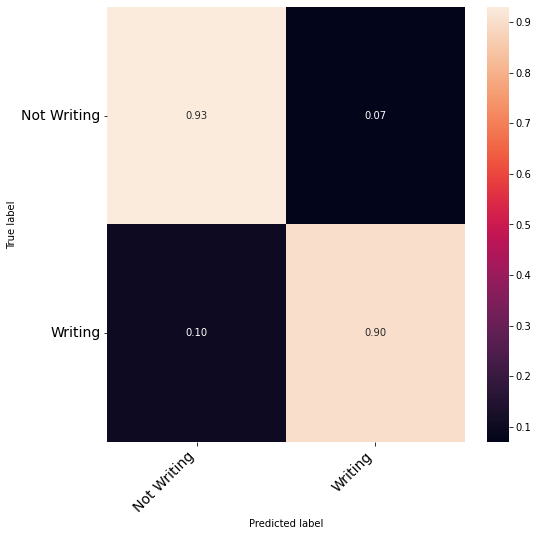

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

#class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A',
 #                 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
  #                 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
   #                'X', 'Y', 'Z']


#class_names = ['0,O,o','1,I,i,l ','2,Z,z','3','4','5,S,s','6,G','7','8','9,a,g,q','A',
 #                  'B', 'C,c', 'D,P,p,b', 'E,e', 'F,f', 'H,h', 'J,j ', 'K,k', 'L',
  #                 'M,m', 'N,n', 'Q','R','T,t', 'U,V,u,v', 'W,w','X,x', 'Y,y', 'd'] 

#class_names = ['0','1','2','3','4','5','6','7','8','9','A',
 #                'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
  #                'M', 'N', 'O', 'P', 'Q', 'R', 'S','T', 'U', 'V', 'W',
   #              'X', 'Y', 'Z','a',
    #             'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
     #             'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w',
      #            'x', 'y', 'z']  


class_names = ['Not Writing','Writing']                   
print_confusion_matrix(cm, class_names)
plt.savefig('Confusion_Matix_.png', dpi=300)


In [50]:
from sklearn.metrics import classification_report

#report = classification_report(y_test, predict,target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A',
 #                  'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
  #                 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
   #                'X', 'Y', 'Z'])

#report = classification_report(y_test, predict,target_names=['0,O,o','1,I,i,l ','2,Z,z','3','4','5,S,s','6,G','7','8','9,a,g,q','A',
 #                  'B', 'C,c', 'D,P,p,b', 'E,e', 'F,f', 'H,h', 'J,j ', 'K,k', 'L',
  #                 'M,m', 'N,n', 'Q','R','T,t', 'U,V,u,v', 'W,w','X,x', 'Y,y', 'd']) 

#report = classification_report(y_test, predict,target_names= ['0','1','2','3','4','5','6','7','8','9','A',
 #                'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
  #               'M', 'N', 'O', 'P', 'Q', 'R', 'S','T', 'U', 'V', 'W',
   #               'X', 'Y', 'Z','a',
    #             'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
     #            'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w',
      #            'x', 'y', 'z']) 


report = classification_report(y_test, predict,target_names= ['Not Writing','Writing'])
print(report)

              precision    recall  f1-score   support

 Not Writing       0.95      0.93      0.94      2424
     Writing       0.86      0.90      0.88      1203

    accuracy                           0.92      3627
   macro avg       0.91      0.92      0.91      3627
weighted avg       0.92      0.92      0.92      3627



In [ ]:
%%capture cap --no-stderr
print(report)

In [ ]:
with open('Classification_Report_62.txt', 'w') as f:
    f.write(cap.stdout)

In [51]:
from collections import Counter


correct = [pred == true for pred, true in zip(predict, y_test)]
correct = np.array(correct).flatten()
print(Counter(correct))

Counter({True: 3338, False: 289})


In [52]:
predict

array([0, 0, 0, ..., 0, 0, 1])

In [53]:
classifiedIndexes = np.where(y_test==predict)[0]
misclassifiedIndexes = np.where(y_test!=predict)[0]